# 16장 순환 신경망으로 시퀀스 데이터 모델링

## 16.1 시퀀스 데이터 소개

### 16.1.1 시퀀스 데이터 모델링: 순서를 고려한다

다른 데이터들과는 다르게 시퀀스 원소들은 특정 순서를 가지므로 상호 독립적이지 않습니다.

### 16.1.2 시퀀스 표현

### 16.1.3 시퀀스 모델링의 종류

어떤 입력데이터와 출력 데이터가 시퀀스라면 데이터는 다음 세 가지 중 하나로 구성됩니다.

* 다대일(many-to-one): 입력 데이터가 시퀀스 입니다. 출력은 시퀀스가 아니라 고정 크기의 벡터입니다. 예를 들어 감성 분석에서 입력은 텍스트고 출력은 클래스 레이블입니다.
* 일대다(one-to-many): 입력 데이터가 시퀀스가 아니라 일반적인 형태입니다. 출력은 시퀀스입니다. 이런 종류의 예로는 이미지 캡셔닝이 있습니다. 입력이 이미지고 출력은 영어 문장입니다.
* 다대다(many-to-many): 입력과 출력 배열이 모두 시퀀스입니다. 이런 종류는 입력과 출력이 동기적인지 아닌지에 따라 더 나눌 수 있습니다. 동기적인 다대다 모델링 작업의 예는 각 프레임이 레이블되어 있는 비디오 분류입니다. 그렇지 않은 다대다 모델의 예는 한 언어에서 다른 언어로 번역하는 작업입니다. 예를 들어 독일어로 번역하기 전에 전체 영어 문장을 읽어 처리합니다.


## 16.2 시퀀스 모델링을 위한 RNN

### 16.2.1 RNN 구조와 데이터 흐름 이해

### 16.2.2 RNN의 활성화 출력 계산

### 16.2.3 긴 시퀀스 학습의 어려움

### 16.2.4 LSTM 유닛


## 16.3 텐서플로의 tf.keras API로 시퀀스 모델링을 위한 다층 RNN 구현

1. 감정 분석
2. 언어 모델링

## 16.4 첫 번째 프로젝트: 다층 RNN으로 IMDb 영화 리뷰의 감성 분석 수행

감성 분석은 문장이나 텍스트 문서에 표현된 의견을 분석하는 것입니다. 이 절에서 다대일 구조로 감성 분석을 위한 다층 RNN을 구현해 보겠습니다.

In [4]:
import pyprind
import pandas as pd
from string import punctuation
import re
import numpy as np

df = pd.read_csv('movie_data.csv', encoding='utf-8')

In [6]:
## df 에는 review 와 sentiment 두개의 컬럼이 있습니다.
## review는 영화 리뷰 텍스트를 담고 있고 sentiment는 0 또는 1 레이블이 들어 있습니다.

## 신경망에 주입할 입력 데이터를 준비하기 위해 텍스트를 정수 값으로 인코딩 해야합니다.
## 이를 위해 전체 데이터셋에서 고유한 단어를 먼저 찾아야 합니다.
## 파이썬의 set을 사용할 수 있지만 대규모 데이터셋에서 고유한 단어를 찾는 데 집합을 사용하는것은
## 효율적이지 않습니다. 더 좋은 방법은 collection 패키지에 있는 Counter를 사용하는 것입니다. 

from collections import Counter

counts = Counter()
pbar = pyprind.ProgBar(len(df['review']), title='단어의 등장 횟수를 카운트합니다.')

for i, review in enumerate(df['review']):
    text = ''.join([c if c not in punctuation else ' ' +c+' ' for c in review]).lower()
    df.loc[i, 'review'] = text
    pbar.update()
    counts.update(text.split())

## 고유한 각 단어를 정수로 매핑하는 
## 딕셔너리를 만듭니다. 

word_counts = sorted(counts, key=counts.get, reverse=True)
print(word_counts[:5])
word_to_int = {word: ii for ii, word in enumerate(word_counts, 1)}

mapped_reviews = []
pbar = pyprind.ProgBar(len(df['review']), title='리뷰를 정수로 매핑합니다.')

for review in df['review']:
    mapped_reviews.append([word_to_int[word] for word in review.split()])
    pbar.update()

단어의 등장 횟수를 카운트합니다.
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:49
리뷰를 정수로 매핑합니다.
['the', '.', ',', 'and', 'a']
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


In [9]:
# mapped_reviews 이걸 확인해봤으나 숫자 데이터만 나와서 데이터 파악이 힘듬

sequence_length = 200 ## (RNN 공식에 있는 T 값입니다)
sequences = np.zeros((len(mapped_reviews), sequence_length), dtype=int)

for i, row in enumerate(mapped_reviews):
    review_arr = np.array(row)
    sequences[i, -len(row):] = review_arr[-sequence_length:]


In [14]:
sequences

array([[  37, 1956, 1801, ...,   85,   34, 1309],
       [   4, 7431,  256, ...,    1, 1980,   41],
       [ 113,  587,    7, ...,  175,   29,    2],
       ...,
       [   0,    0,    0, ...,    3,  139,    2],
       [   0,    0,    0, ...,   14,   10,    2],
       [   0,    0,    0, ...,  190,   85,   29]])

In [12]:
# 데이터셋을 전처리한 후 데이터를 훈련 세트와 테스트 세트로 나눕니다. 이미 데이터가 무작위로 섞여 있기 때문에
# 처음 75%를 훈련 세트로 선택하고 나머지 25%를 테스트 세트로 사용합니다. 

X_train = sequences[:37500,:]
y_train = df.loc[:37499, 'sentiment'].values
X_test = sequences[37500:,:]
y_test = df.loc[37500:, 'sentiment'].values

In [13]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(37500, 200) (37500,) (12500, 200) (12500,)


In [16]:
# 패딩 문자를 포함한 전체 단어의 수는 102967개 입니다. 

n_words = len(word_to_int) + 1
print(n_words)

102967


In [18]:
### 16.4.2 임베딩

from tensorflow.keras import models, layers
model = models.Sequential()
model.add(layers.Embedding(n_words, 200, embeddings_regularizer='l2'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         20593400  
Total params: 20,593,400
Trainable params: 20,593,400
Non-trainable params: 0
_________________________________________________________________


In [20]:
### 16.4.3 RNN 모델 만들기

model.add(layers.LSTM(16))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         20593400  
_________________________________________________________________
lstm (LSTM)                  (None, 16)                13888     
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 20,607,305
Trainable params: 20,607,305
Non-trainable params: 0
_________________________________________________________________


In [23]:
### 16.4.4 감정 분석 RNN 모델 훈련

# 모델 구성을 완려했으므로 Adam 옵티마이저를 사용하여 모델을 컴파일하도록 하겠습니다. 
# 감성 분석 문제는 이진 분류 문제이므로 손실 함수는 binary_crossentropy로 지정합니다. 

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [30]:
import time
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

callback_list = [ModelCheckpoint(filepath='sentiment_rnn_checkpoint.h5', monitor='val_loss',save_best_only=True), TensorBoard(log_dir="sentiment_rnn_logs\\{}".format(time.strftime('%Y-%m-%d-%H_%M_%S')))]

In [31]:
history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_split=0.3, callbacks=callback_list)

Train on 26250 samples, validate on 11250 samples
Epoch 1/10
26250/26250 [==============================] - 162s 6ms/sample - loss: 6.5343 - acc: 0.7058 - val_loss: 0.6595 - val_acc: 0.8014
Epoch 2/10
26250/26250 [==============================] - 163s 6ms/sample - loss: 0.6205 - acc: 0.8256 - val_loss: 0.5984 - val_acc: 0.8258
Epoch 3/10
26250/26250 [==============================] - 164s 6ms/sample - loss: 0.5635 - acc: 0.8462 - val_loss: 0.5569 - val_acc: 0.8540
Epoch 4/10
26250/26250 [==============================] - 166s 6ms/sample - loss: 0.5321 - acc: 0.8584 - val_loss: 0.5316 - val_acc: 0.8574
Epoch 5/10
26250/26250 [==============================] - 166s 6ms/sample - loss: 0.5163 - acc: 0.8671 - val_loss: 0.4999 - val_acc: 0.8702
Epoch 6/10
26250/26250 [==============================] - 165s 6ms/sample - loss: 0.5080 - acc: 0.8718 - val_loss: 0.5146 - val_acc: 0.8614
Epoch 7/10
26250/26250 [==============================] - 165s 6ms/sample - loss: 0.4920 - acc: 0.8779 - val_l

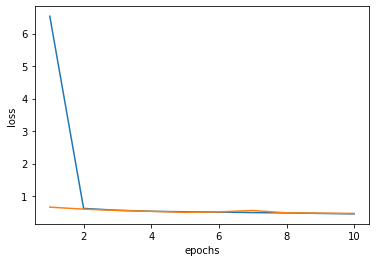

In [32]:
import matplotlib.pyplot as plt

epochs = np.arange(1, 11)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

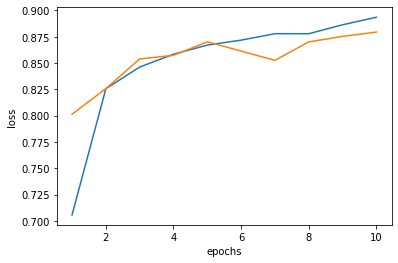

In [33]:
epochs = np.arange(1, 11)
plt.plot(epochs, history.history['acc'])
plt.plot(epochs, history.history['val_acc'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [35]:
## 16.4.5 감성 분석 RNN 모델 평가

model.load_weights('sentiment_rnn_checkpoint.h5')
model.evaluate(X_test, y_test)

[0.46814299768447876, 0.8768]

In [36]:
model.predict_proba(X_test[:10])

array([[0.00790909],
       [0.02968219],
       [0.00355786],
       [0.9257138 ],
       [0.9803586 ],
       [0.9942386 ],
       [0.03114456],
       [0.87110496],
       [0.0100283 ],
       [0.7045422 ]], dtype=float32)

In [37]:
model.predict_classes(X_test[:10])

array([[0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1]])

## 16.5 두 번째 프로젝트: 텐서플로로 글자 단위 언어 모델 구현

그래디언트 폭주 문제를 피하기 위한 그래디언트 클리핑 기법 사용 예정

### 16.5.1 데이터 전처리



In [39]:
import numpy as np

with open('pg2265.txt', 'r', encoding='utf-8') as f:
    text=f.read()

text = text[15858:]
chars = set(text)
char2int = {ch:i for i,ch in enumerate(chars)}
int2char = dict(enumerate(chars))
text_ints = np.array([char2int[ch] for ch in text], dtype=np.int32)

In [40]:
len(text)

162849

In [41]:
len(chars)

65

In [42]:
def reshape_data(sequence, batch_size, num_steps):
    mini_batch_length = batch_size * num_steps
    num_batches = int(len(sequence) / mini_batch_length)
    if num_batches*mini_batch_length + 1 > len(sequence):
        num_batches = num_batches - 1

    ## 전체 배치에 포함되지 않는 시퀀스 끝부분은 삭제합니다
    x = sequence[0: num_batches*mini_batch_length]
    y = sequence[1: num_batches*mini_batch_length + 1]

    ## x와 y를 시퀀스 배치의 리스트로 나눕니다
    x_batch_splits = np.split(x, batch_size)
    y_batch_splits = np.split(y, batch_size)

    ## 합쳐진 배치 크기는
    ## batch_size x mini_batch_length가 됩니다. 
    x = np.stack(x_batch_splits)
    y = np.stack(y_batch_splits)

    return x,y

In [43]:
## 테스트
train_x, train_y = reshape_data(text_ints, 64, 10)
print(train_x.shape)

(64, 2540)


In [44]:
print(train_x[0, :10])
print(train_y[0, :10])
print(''.join(int2char[i] for i in train_x[0, :10]))
print(''.join(int2char[i] for i in train_y[0, :10]))

[18 63 39 62 18 42 54 35 39  0]
[63 39 62 18 42 54 35 39  0 32]
The Traged
he Tragedi


In [45]:
def create_batch_generator(data_x, data_y, num_steps):
    batch_size, tot_batch_length = data_x.shape[0:2]
    num_batches = int(tot_batch_length/num_steps)
    for b in range(num_batches):
        yield (data_x[:, b*num_steps:(b+1)*num_steps], data_y[:, b*num_steps:(b+1)*num_steps])

In [52]:
bgen = create_batch_generator(train_x[:, :100], train_y[:, :100], 15)
for x, y in bgen:
    print(x.shape, y.shape, end=' ')
    print(''.join(int2char[i] for i in x[0,:]).replace('\n', '*'), 
            ' ', 
            ''.join(int2char[i] for i in y[0,:]).replace('\n', '*'))

(64, 15) (64, 15) The Tragedie of   he Tragedie of 
(64, 15) (64, 15)  Hamlet**Actus    Hamlet**Actus P
(64, 15) (64, 15) Primus. Scoena    rimus. Scoena P
(64, 15) (64, 15) Prima.**Enter B   rima.**Enter Ba
(64, 15) (64, 15) arnardo and Fra   rnardo and Fran
(64, 15) (64, 15) ncisco two Cent   cisco two Centi


In [53]:
batch_size = 64
num_steps = 100
train_x, train_y = reshape_data(text_ints, batch_size, num_steps)
print(train_x.shape, train_y.shape)

(64, 2500) (64, 2500)


In [54]:
from tensorflow.keras.utils import to_categorical

train_encoded_x = to_categorical(train_x)
train_encoded_y = to_categorical(train_y)
print(train_encoded_x.shape, train_encoded_y.shape)

(64, 2500, 65) (64, 2500, 65)


In [55]:
print(np.max(train_x), np.max(train_y))

64 64


In [58]:
### 16.5.2 글자 단위 RNN 모델 만들기

char_model = models.Sequential()
num_classes = len(chars)

char_model.add(layers.LSTM(128, input_shape=(None, num_classes), return_sequences=True))
char_model.add(layers.TimeDistributed(layers.Dense(num_classes, activation='softmax')))

In [59]:
char_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 128)         99328     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 65)          8385      
Total params: 107,713
Trainable params: 107,713
Non-trainable params: 0
_________________________________________________________________


In [63]:
from tensorflow.keras.optimizers import Adam

adam = Adam(clipnorm=5.0)
char_model.compile(loss='categorical_crossentropy', optimizer=adam)
callback_list = [ModelCheckpoint(filepath='char_rnn_checkpoint.h5')]

for i in range(500):
    bgen = create_batch_generator(train_encoded_x, train_encoded_y, num_steps)
    char_model.fit_generator(bgen, steps_per_epoch=50, epochs=1, callbacks=callback_list, verbose=True)

 6/50 [==>...........................] - ETA: 22s - loss: 1.7681

KeyboardInterrupt: 